In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"goddrew","key":"715d16660a79d047c4d43e0a0db7cdcd"}'}

In [ ]:
!~!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: ~!rm: command not found


In [ ]:
!kaggle datasets download -d arnaud58/landscape-pictures

100% 620M/620M [00:29<00:00, 24.5MB/s]
100% 620M/620M [00:29<00:00, 22.0MB/s]


In [ ]:
!unzip landscape-pictures.zip -d /content/train

Archive:  landscape-pictures.zip
  inflating: /content/train/00000000.jpg  
  inflating: /content/train/00000000_(2).jpg  
  inflating: /content/train/00000000_(3).jpg  
  inflating: /content/train/00000000_(4).jpg  
  inflating: /content/train/00000000_(5).jpg  
  inflating: /content/train/00000000_(6).jpg  
  inflating: /content/train/00000000_(7).jpg  
  inflating: /content/train/00000001.jpg  
  inflating: /content/train/00000001_(2).jpg  
  inflating: /content/train/00000001_(3).jpg  
  inflating: /content/train/00000001_(4).jpg  
  inflating: /content/train/00000001_(5).jpg  
  inflating: /content/train/00000001_(6).jpg  
  inflating: /content/train/00000001_(7).jpg  
  inflating: /content/train/00000002.jpg  
  inflating: /content/train/00000002_(2).jpg  
  inflating: /content/train/00000002_(3).jpg  
  inflating: /content/train/00000002_(4).jpg  
  inflating: /content/train/00000002_(5).jpg  
  inflating: /content/train/00000002_(6).jpg  
  inflating: /content/train/00000003.jp

In [ ]:
%cd /content/train

/content/train


In [ ]:
%%shell 
a=0
for i in *.jpg; do
  new=$(printf "%06d.jpg" "$a") 
  mv -- "$i" "$new"
  let a=a+1
done

In [ ]:
import os, os.path
import numpy as np
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 

import torchvision
from torchvision.io import ImageReadMode
from torchvision import datasets
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.io import read_image

from PIL import Image

In [ ]:
class CustomImageDataset(Dataset): 
  def __init__(self, img_dir, transform=None): 
    self.img_dir = img_dir 
    self.transform = transform 
    self.length = len([name for name in os.listdir(self.img_dir) if os.path.isfile(name)])

  def __len__(self): 
    return self.length 
  
  def __getitem__(self, idx): 
    img_path = os.path.join(self.img_dir, '{:06d}'.format(idx) + '.jpg')
    if Image.open(img_path).mode == 'CMYK':
      image = Image.open(img_path).convert("RGB")
      pix = np.array(image)
      image = torch.from_numpy(pix)
      image = image.permute(2, 0, 1)
    else: 
      image = read_image(img_path, mode=ImageReadMode.RGB)
      
    image = image.float()
    if self.transform: 
      image = self.transform(image)
    return image 


In [ ]:
img_size = 64 

train_dataset = CustomImageDataset("/content/train",
                                   transform=transforms.Compose([
                                       transforms.RandomResizedCrop(img_size),
                                       transforms.RandomHorizontalFlip(p=0.5), 
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])) 

# train_dataset = CustomImageDataset("/content/train",
#                                    transform=transforms.Compose([
#                                        transforms.Resize(img_size), 
#                                        transforms.RandomResizedCrop(img_size),
#                                        transforms.RandomHorizontalFlip(p=0.5), 
#                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                    ])) 

In [ ]:
print("Number of training data:", len(train_dataset))

Number of training data: 4319


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

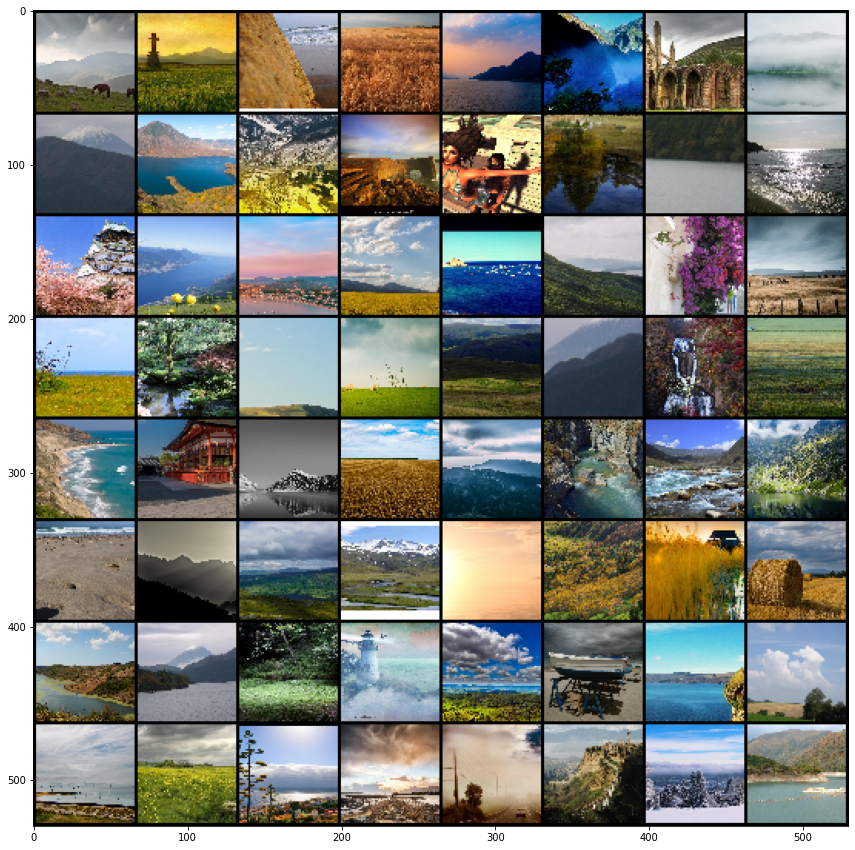

In [ ]:
example_batch = next(iter(train_dataloader))

plt.figure(figsize=(15, 15))
plt.axis=("off")
plt.imshow(np.transpose(vutils.make_grid(example_batch[:64], padding=2, normalize=True), (1, 2, 0)))

In [ ]:
class Generator(nn.Module): 
  def __init__(self): 
    super(Generator, self).__init__()
    
    self.conv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, bias=False)      
    self.bn1 = nn.BatchNorm2d(512) 
    self.relu1 = nn.ReLU()


    self.conv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(256)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()

    self.conv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn4 = nn.BatchNorm2d(64)
    self.relu4 = nn.ReLU()

    self.conv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)
    self.tanh1 = nn.Tanh()

  def _forward_imp(self, x: torch.Tensor) -> torch.Tensor: 
    x = self.conv1(x)
    x = self.bn1(x) 
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu3(x)

    x = self.conv4(x)
    x = self.bn4(x)
    x = self.relu4(x)

    x = self.conv5(x)
    x = self.tanh1(x)

    return x
  
  def forward(self, x): 
    return self._forward_imp(x)

In [ ]:
class Discriminator(nn.Module): 
  def __init__(self): 
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
    self.leaky1 = nn.LeakyReLU(0.2)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(128)    
    self.leaky2 = nn.LeakyReLU(0.2)

    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(256)
    self.leaky3 = nn.LeakyReLU(0.2)

    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(512)
    self.leaky4 = nn.LeakyReLU(0.2)

    self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
    self.sigmoid1 = nn.Sigmoid()

  def _forward_imp(self, x: torch.Tensor) -> torch.Tensor: 
    x = self.conv1(x)
    x = self.leaky1(x)

    x = self.conv2(x)
    x = self.bn1(x)
    x = self.leaky2(x)
  
    x = self.conv3(x)
    x = self.bn2(x)
    x = self.leaky3(x)

    x = self.conv4(x)
    x = self.bn3(x) 
    x = self.leaky4(x)

    x = self.conv5(x)
    x = self.sigmoid1(x)

    return x 

  def forward(self, x): 
    return self._forward_imp(x)

In [ ]:
def init_weight(m): 
  classname = m.__class__.__name__
  if classname.find('Conv') != -1: 
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1: 
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
netG = Generator()
netD = Discriminator()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

netG.to(device)
netD.to(device)

netG.apply(init_weight)
netD.apply(init_weight)
print("Weight init Done!")

print(netG)
print(netD)

Weight init Done!
Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh1): Tanh()
)
Discriminator(
  (conv1): Conv2d(3, 64, 

In [ ]:
loss = nn.BCELoss()

beta1 = 0.5 
lr = 0.0001

netG_optim = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
netD_optim = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [ ]:
epochs = 30
k_steps = 1
G_losses = []
D_losses = []
img_list = []
iters = 0
real_label = 1.
fake_label = 0.

print("Start Training")
for epoch in range(epochs): 
  for batch, X in enumerate(train_dataloader): 

    label = None 
    D_x = None 
    D_G = None 
    errorD = None 
    noise = None 

    for i in range(k_steps):
    # Updating Discriminator Network 
      netD.zero_grad()
      X = X.to(device)
      X_size = X.size(0)
      label = torch.full((X_size,), real_label, dtype=torch.float, device=device)
      output = netD(X).view(-1)
      errorD_true = loss(output, label)
      errorD_true.backward()
      D_x = output.mean().item() # 

      noise = torch.randn(X_size, 100, 1, 1, device=device) 
      fake = netG(noise)
      label.fill_(fake_label)
      output = netD(fake.detach()).view(-1)
      errorD_fake = loss(output, label)
      errorD_fake.backward()
      D_G = output.mean().item() #

      errorD = errorD_true + errorD_fake
      netD_optim.step()
  
    # Updating Generator Network
    netG.zero_grad()
    label.fill_(real_label)
    output = netD(fake).view(-1)
    errorG = loss(output, label)
    errorG.backward()
    D_G_2 = output.mean().item()

    netG_optim.step()

    if batch % 10 == 0: 
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, epochs, batch, len(train_dataloader),errorD.item(), errorG.item(), D_x, D_G, D_G_2))

    G_losses.append(errorG.item())
    D_losses.append(errorD.item())

    if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1
    


print("DONE!")

Start Training
[0/30][0/68]	Loss_D: 1.7784	Loss_G: 2.1419	D(x): 0.3307	D(G(z)): 0.3399 / 0.1449
[0/30][10/68]	Loss_D: 0.2063	Loss_G: 4.7836	D(x): 0.9542	D(G(z)): 0.1367 / 0.0128
[0/30][20/68]	Loss_D: 0.1311	Loss_G: 5.8467	D(x): 0.9888	D(G(z)): 0.1085 / 0.0038
[0/30][30/68]	Loss_D: 0.1973	Loss_G: 6.5807	D(x): 0.9557	D(G(z)): 0.0879 / 0.0020
[0/30][40/68]	Loss_D: 0.2143	Loss_G: 9.5443	D(x): 0.8423	D(G(z)): 0.0023 / 0.0001
[0/30][50/68]	Loss_D: 0.3583	Loss_G: 13.5766	D(x): 0.9935	D(G(z)): 0.2727 / 0.0000
[0/30][60/68]	Loss_D: 0.4588	Loss_G: 13.7621	D(x): 0.7316	D(G(z)): 0.0001 / 0.0000
[1/30][0/68]	Loss_D: 0.1142	Loss_G: 7.4271	D(x): 0.9265	D(G(z)): 0.0276 / 0.0011
[1/30][10/68]	Loss_D: 0.0142	Loss_G: 8.2971	D(x): 0.9871	D(G(z)): 0.0002 / 0.0006
[1/30][20/68]	Loss_D: 0.1196	Loss_G: 4.8386	D(x): 0.9726	D(G(z)): 0.0439 / 0.0186
[1/30][30/68]	Loss_D: 0.4282	Loss_G: 14.2717	D(x): 0.9926	D(G(z)): 0.3154 / 0.0000
[1/30][40/68]	Loss_D: 0.1654	Loss_G: 7.3345	D(x): 0.8997	D(G(z)): 0.0107 / 0.0010


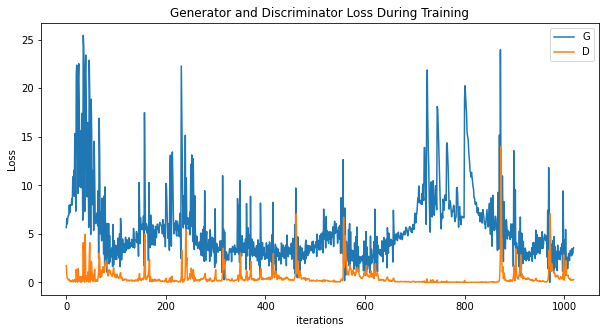

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

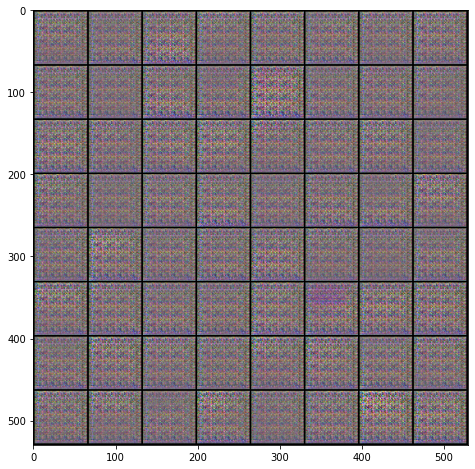

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis=("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
plt.figure(figsize=(15, 15))
plt.axis=("off")

with torch.no_grad():
  fake = netG(fixed_noise).detach().cpu()

plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))